## Requirements

In [ ]:
!pip install transformers==4.30
!pip install -q transformers datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install umap-learn
!pip install -U imbalanced-learn
!pip3 install Cython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.5 MB/s eta 0:00

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from umap import UMAP
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report)
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import (StratifiedKFold, cross_val_score, GridSearchCV)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import datasets
from datasets import Dataset, DatasetDict
from datasets import load_dataset
from datasets import Features, Value, ClassLabel

from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import Trainer
from transformers import AutoModel
from transformers import pipeline

from torch.nn.functional import cross_entropy


## UDF

In [ ]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

def analyze_error_test_set(df_encoded_src):
    # Convert our dataset back to PyTorch tensors
    df_encoded_src.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    # Compute loss values
    df_encoded_src["validation"] = df_encoded_src["validation"].map(
        forward_pass_with_label, batched=True, batch_size=16)
    df_encoded_src.set_format("pandas")
    cols = ["text", "label", "predicted_label", "loss"]
    df_test = df_encoded_src["validation"][:][cols]
    df_test["predicted_label"] = df_test["predicted_label"]
    df_test["label"] = df_test["label"].apply(lambda x: label_int2str.get(x))
    df_test["predicted_label"] = df_test["predicted_label"].apply(lambda x: label_int2str.get(x))
    return df_test

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

def encode_dataset(df_source):
  df_encoded = df_source.map(tokenize, batched=True, batch_size=None)
  df_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
  return df_encoded

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

def extract_hidden_states_df(df_source):
  df_encoded = encode_dataset(df_source)
  df_hidden = df_encoded.map(extract_hidden_states, batched=True)
#   torch.cuda.empty_cache()
  return df_hidden


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

def measure_model_performance(trainer, df_input, y_labels, labels_list):
    preds_output = trainer.predict(df_input)
    print(preds_output.metrics)
    y_preds = np.argmax(preds_output.predictions, axis=1)
    plot_confusion_matrix(y_preds, y_labels, labels_list)

def train_model(model_ckpt, training_args, df_encoded_src, num_labels):
    # Create Model
    model = (AutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels)
            .to(device))
    model_name = f"models/{model_ckpt}-finetuned-turkish-tweets"
    training_args.output_dir = model_name
    trainer = Trainer(model=model, args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=df_encoded_src["train"],
                    eval_dataset=df_encoded_src["validation"],
                    tokenizer=tokenizer)
    trainer.train()
    return trainer

# Load Dataset

In [ ]:
#### Data Preparation step.
#### input the final_preprocessed_df.csv file path here
df = pd.read_csv('https://media.githubusercontent.com/media/Branden-Kang/LLaMA-2/main/data/final_preprocessed_df2.csv')


<ipython-input-4-7b6bf60736bb>:3: DtypeWarning: Columns (0,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://media.githubusercontent.com/media/Branden-Kang/LLaMA-2/main/data/final_preprocessed_df2.csv')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133678 entries, 0 to 133677
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   133678 non-null  object 
 1   subreddit                    133668 non-null  object 
 2   author                       133668 non-null  object 
 3   over_18                      133668 non-null  object 
 4   link_flair_text              19278 non-null   object 
 5   title                        133660 non-null  object 
 6   selftext                     133660 non-null  object 
 7   url                          133642 non-null  object 
 8   created_utc                  133656 non-null  object 
 9   title_with_selftext          133656 non-null  object 
 10  title_with_selftext_cleaned  133656 non-null  object 
 11  polarity                     133656 non-null  float64
 12  class_group                  133656 non-null  object 
dtyp

In [ ]:
df.head(3)

,Unnamed: 0,subreddit,author,over_18,link_flair_text,title,selftext,url,created_utc,title_with_selftext,title_with_selftext_cleaned,polarity,class_group
0,141414,depression,[deleted],False,NaN,"I've been chronically depressed for 4 years, n...","First of all, it's impossible to begin the sto...",http://www.reddit.com/r/depression/comments/2o...,2014-12-04 13:51:15,"I've been chronically depressed for 4 years, n...",chronically depressed year getting worse need...,-0.004304,Depression_Group
1,290280,depression,bbybroccoli,False,NaN,Has anyone had bad side effects on Wellbutrin ...,"I just started it last Wednesday, 150 mg in th...",https://www.reddit.com/r/depression/comments/4...,2016-08-22 15:12:43,Has anyone had bad side effects on Wellbutrin ...,anyone bad side effect wellbutrin bupropion ...,0.154464,Depression_Group
2,255110,depression,onlyindarkness,False,NaN,I want to live at the hospital.,The therapist I met with Friday afternoon aske...,https://www.reddit.com/r/depression/comments/4...,2016-04-17 02:03:20,I want to live at the hospital. The therapist ...,want live hospital therapist met friday after...,0.037710,Depression_Group


## Data Pre-processing

In [ ]:
#### Pre-processing Step 0. Build dataframe for modeling : select only necessary features
df_pre = df[['title_with_selftext','class_group']]
df_pre.columns = ['text','label_str']

In [ ]:
df_pre.head(3)

,text,label_str
0,"I've been chronically depressed for 4 years, n...",Depression_Group
1,Has anyone had bad side effects on Wellbutrin ...,Depression_Group
2,I want to live at the hospital. The therapist ...,Depression_Group


In [ ]:
#### Pre-processing Step 1. Check the class distribution
df_pre.label_str.value_counts()

label_str
Depression_Group    44733
Neutral_Group       44663
Happy_Group         44260
Name: count, dtype: int64

In [ ]:
#### Pre-processing Step 2. Check the missing values
print(df_pre['label_str'].isnull().sum())
df_pre[df_pre['label_str'].isnull()].transpose()

22


,7202,7203,7204,7205,7206,17853,17854,17855,17856,17857,...,17860,17861,26451,26452,26453,26454,26455,32557,32558,32559
text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label_str,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#### Pre-processing Step 2-1. Missing value treatmnet
df_pre = df_pre.dropna(subset='label_str')

In [ ]:
#### Pre-processing Step 3-1.Generate label feature for modeling
df_pre['label'] = df_pre.label_str.map({
    'Depression_Group': 0,
    'Neutral_Group': 1,
    'Happy_Group': 2,
})

#### Pre-processing Step 4. Select relevant features
df_pre = df_pre[['text','label']]
df_pre.head(3)

,text,label
0,"I've been chronically depressed for 4 years, n...",0
1,Has anyone had bad side effects on Wellbutrin ...,0
2,I want to live at the hospital. The therapist ...,0


## Modeling  

In [ ]:
#### Modeling Step 1. Modeling Data Preparation
###### Generate class dataset
df_depression = df_pre[df_pre.label==0]
df_neutral = df_pre[df_pre.label==1]
df_happy = df_pre[df_pre.label==2]

###### Generate randomly sampled class dataset
df_depression_sampled = resample(df_depression, replace=True, n_samples=10000, random_state=42) # reproducible results
df_neutral_sampled = resample(df_neutral, replace=True, n_samples=10000, random_state=42) # reproducible results
df_happy_sampled = resample(df_happy, replace=True, n_samples=10000, random_state=42) # reproducible results

###### Concat sampled dataset
df_sampled = pd.concat([df_depression_sampled, df_neutral_sampled, df_happy_sampled])
###### Check the sample distribution for classes
df_sampled.label.value_counts()

label
0    10000
1    10000
2    10000
Name: count, dtype: int64

In [ ]:
#### Modeling Step 2. Dataset Split (train / validation / test) : 75% / 15% / 10 % respectively
df_train_dataset, df_validation_dataset, df_test_dataset = \
  np.split(df_sampled.sample(frac=1, random_state=42), [int(.75*len(df_sampled)), int(.9*len(df_sampled))])

###### Check the train/ validation / test count after the split
print(f'train data size : {len(df_train_dataset)}')
print(f'validation data size : {len(df_validation_dataset)}')
print(f'test data size : {len(df_test_dataset)}')

###### Save it as csv for load
df_train_dataset.to_csv('train_dataset.csv', index=False)
df_validation_dataset.to_csv('validation_dataset.csv', index=False)
df_test_dataset.to_csv('test_dataset.csv', index=False)


###### Formatted data as 'DatasetDict' type for the further modeling step
class_names = ["Depression_Group", "Neutral_Group", "Happy_Group"]
sentiment_features = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)}) ### feature maping from integer to class
file_dict = {'train': 'train_dataset.csv',
             'validation':'validation_dataset.csv',
             'test': 'test_dataset.csv'}
dataset = load_dataset('csv', data_files=file_dict, delimiter=",", column_names=['text', 'label'], features=sentiment_features, skiprows=1)

train data size : 22500
validation data size : 4500
test data size : 3000


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
### DatasetDict format checking
dataset.set_format(type="pandas")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22500
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3000
    })
})

In [ ]:
#### Modeling Step 3.label maping Convert Label From Integer to String
###### check the label name and number
print(set(dataset['train']['label']))
print(dataset['train'].features['label'])


###### Build the train/ validation / test dataset with label mapping
df_train = dataset["train"][:]
df_test = dataset["test"][:]
df_validation = dataset["validation"][:]

df_train["label_str"] = df_train["label"].apply(label_int2str)
df_test["label_str"] = df_test["label"].apply(label_int2str)
df_validation["label_str"] = df_validation["label"].apply(label_int2str)

print(df_train.shape)
print(df_validation.shape)
print(df_test.shape)

{0, 1, 2}
ClassLabel(names=['Depression_Group', 'Neutral_Group', 'Happy_Group'], id=None)
(22500, 3)
(4500, 3)
(3000, 3)


In [ ]:
df_train.head(3)

,text,label,label_str
0,How do you go about telling someone how you fe...,0,Depression_Group
1,"Hey, happy people! What career field do you wo...",2,Happy_Group
2,My mom's bone marrow recipient is doing well! ...,2,Happy_Group


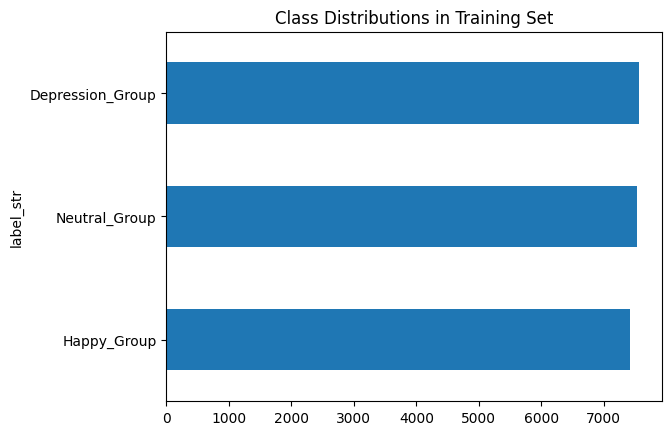

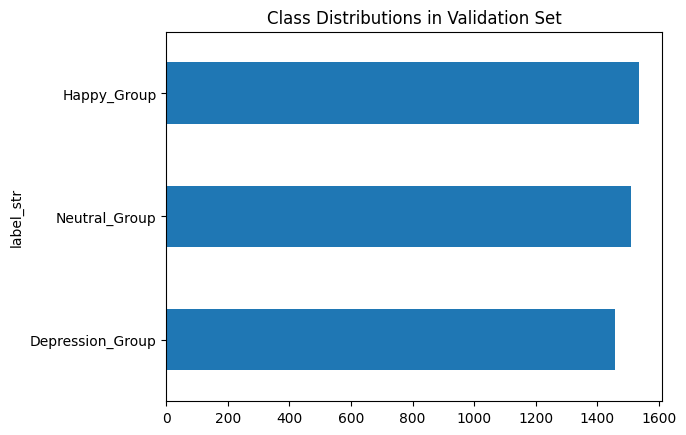

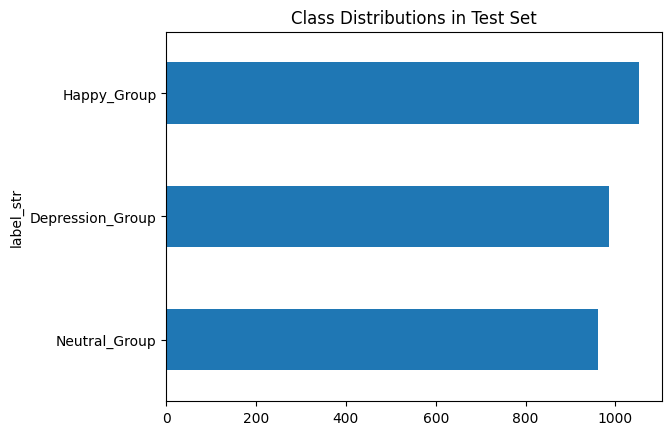

In [ ]:
#### Modeling Step 4. Class distribution Inspection

###### Class Distributions in Training Set
df_train["label_str"].value_counts(ascending=True).plot.barh()
plt.title("Class Distributions in Training Set")
plt.show()

###### Class Distributions in Validation Set
plt.title("Class Distributions in Validation Set")
df_validation["label_str"].value_counts(ascending=True).plot.barh()
plt.show()

###### Class Distributions in Test Set
plt.title("Class Distributions in Test Set")
df_test["label_str"].value_counts(ascending=True).plot.barh()
plt.show()

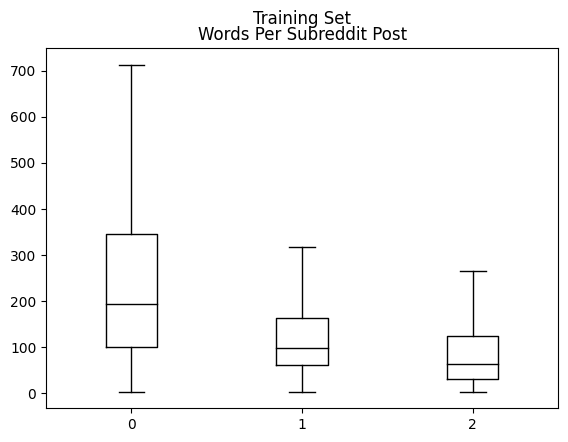

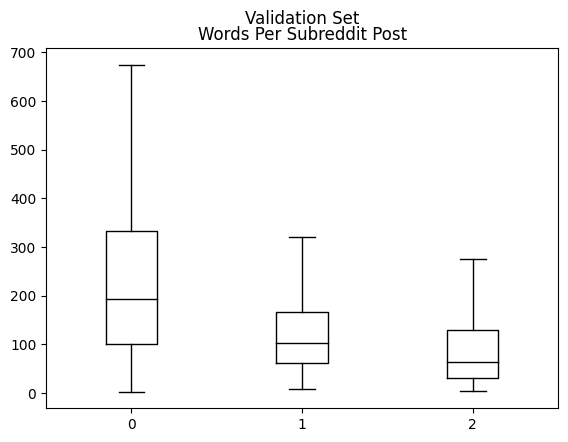

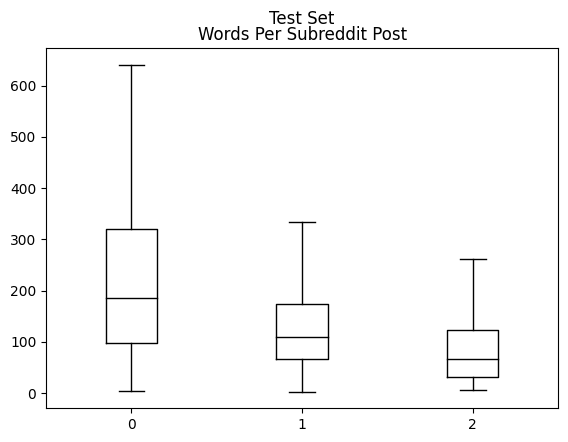

In [ ]:
#### Modeling Step 5. Subreddit sample length distribution

df_train["Words Per Subreddit Post"] = df_train["text"].str.split().apply(len)
df_train.boxplot("Words Per Subreddit Post", by="label", grid=False,
 showfliers=False, color="black")
plt.suptitle("Training Set")
plt.xlabel("")
plt.show()
df_train.drop(columns=['Words Per Subreddit Post'],inplace=True)

df_validation["Words Per Subreddit Post"] = df_validation["text"].str.split().apply(len)
df_validation.boxplot("Words Per Subreddit Post", by="label", grid=False,
 showfliers=False, color="black")
plt.suptitle("Validation Set")
plt.xlabel("")
plt.show()
df_validation.drop(columns=['Words Per Subreddit Post'],inplace=True)

df_test["Words Per Subreddit Post"] = df_test["text"].str.split().apply(len)
df_test.boxplot("Words Per Subreddit Post", by="label", grid=False,
 showfliers=False, color="black")
plt.suptitle("Test Set")
plt.xlabel("")
plt.show()
df_test.drop(columns=['Words Per Subreddit Post'],inplace=True)

In [ ]:
#### Modeling Step 6. Modeling loading & Tokenization
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

##### example case output after tokenization
encoded_text = tokenizer("I am so depressed")
print("encoded_text: ",encoded_text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(encoded_text,len(encoded_text.input_ids))
print(tokens)

print(tokenizer.convert_tokens_to_string(tokens))

print("tokenizer.vocab_size:",tokenizer.vocab_size)
print("Model max context length:",tokenizer.model_max_length)


###### case output
text_raw = df_train['text'][2]
tokenized_text = tokenizer(text_raw) # raw text converted to index numbers
tokenized_text_tokens = tokenizer.convert_ids_to_tokens(tokenized_text.input_ids)
print("tokenized_text - indices: ",tokenized_text['input_ids'])
print("tokenized_text - attention mask: ",tokenized_text['attention_mask'])
print("tokenized_text_tokens: ",tokenized_text_tokens)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

encoded_text:  {'input_ids': [101, 1045, 2572, 2061, 14777, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}
{'input_ids': [101, 1045, 2572, 2061, 14777, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]} 6
['[CLS]', 'i', 'am', 'so', 'depressed', '[SEP]']
[CLS] i am so depressed [SEP]
tokenizer.vocab_size: 30522
Model max context length: 512
tokenized_text - indices:  [101, 2026, 3566, 1005, 1055, 5923, 24960, 7799, 2003, 2725, 2092, 999, 2026, 3566, 2038, 2042, 2006, 1996, 1031, 5923, 24960, 15009, 15584, 1033, 1006, 8299, 1024, 1013, 1013, 7479, 1012, 24960, 1012, 8917, 1013, 1007, 2005, 2086, 1998, 2288, 11925, 2197, 2095, 1010, 2253, 1998, 6955, 1999, 2220, 2251, 1012, 1012, 1012, 1998, 2014, 7799, 1005, 1055, 2219, 5923, 24960, 2134, 1005, 1056, 2131, 3294, 2730, 2125, 2077, 1996, 22291, 1012, 2016, 6955, 2153, 2157, 2077, 15060, 2021, 2010, 9592, 2020, 2025, 3053, 2004, 2204, 2004, 1996, 2034, 2051, 1010, 2242, 2066, 1037, 2382, 1003, 3382, 1997, 2437, 2009, 1010, 2021, 2016, 2288, 2019, 103

In [ ]:
#### example output

In [ ]:
df_input_ids = pd.DataFrame(tokenizer(list(df_train['text'][:3]))['input_ids'])
df_input_ids

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
0,101,2129,2079,2017,2175,2055,4129,2619,2129,2017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,4931,1010,3407,2111,999,2054,2476,2492,2079,...,7780.0,1012.0,4283.0,2061.0,2172.0,2005.0,2115.0,2393.0,999.0,102.0
2,101,2026,3566,1005,1055,5923,24960,7799,2003,2725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_attention_mask = pd.DataFrame(tokenizer(list(df_train['text'][:3]))['attention_mask'])
df_attention_mask

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
0,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
###### train / test tokenization
df_train = Dataset.from_pandas(df_train)
df_test = Dataset.from_pandas(df_test)
df_encoded_train = df_train.map(tokenize, batched=True, batch_size=None)
df_encoded_test = df_test.map(tokenize, batched=True, batch_size=None)

tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
tokens2ids

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

[('[UNK]', 100), ('[SEP]', 102), ('[PAD]', 0), ('[CLS]', 101), ('[MASK]', 103)]

In [ ]:
###### label encoding
le = LabelEncoder()
le.fit(dataset['train'].features['label'].names)
##### label int to string mapping
labels_int_list = list(np.unique(dataset['train']['label']))
label_int2str = dict.fromkeys(labels_int_list)
label_int2str = {k:le.inverse_transform([k])[0] for k,v in label_int2str.items()}
label_int2str

{0: 'Depression_Group', 1: 'Happy_Group', 2: 'Neutral_Group'}

In [ ]:
#### Modeling Step 7. Load pretrained DistilBERT-Base-Uncased Model as Feature Extractor

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)
model = AutoModel.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


device:  cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#### Modeling Step 8. Extracting the last hidden states
np.object = object
dataset.reset_format() # It is imported to reset to huggingface dataset format when extracting features
df_hidden = extract_hidden_states_df(dataset)
df_hidden

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 22500
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 3000
    })
})

In [ ]:
###### Apply hidden_state information
X_train = np.array(df_hidden["train"]["hidden_state"])
X_valid = np.array(df_hidden["validation"]["hidden_state"])
X_test = np.array(df_hidden["test"]["hidden_state"])

y_train = np.array(df_hidden["train"]["label"])
y_valid = np.array(df_hidden["validation"]["label"])
y_test = np.array(df_hidden["test"]["label"])

X_train.shape, y_train.shape

((22500, 768), (22500,))

### Training Methodology: Fine Tuning BERT

In [ ]:
#### Modeling step 9. Training Methodology - Fine Tuning BERT Create dataset
df_encoded = encode_dataset(dataset)
df_encoded

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 22500
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
})

# Hyperparameter tuning (wandb)

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login() # After signing up for wandb, you must enter the API

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Define sweep config
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    # 'metric': {'goal': 'maximize', 'name': 'val_acc'},
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters':
    {
        'batch_size': {'values': [32, 64, 128]},
        'epochs': {'values': [5, 10, 15]},
        'weight_decay': {'values': [1e-2, 1e-3, 1e-4]},
        'lr': {'max': 2e-04, 'min': 1e-05}
     }
}

# Initialize sweep by passing in config. (Optional) Provide a name of the project.
sweep_id = wandb.sweep(sweep=sweep_configuration, project='my-bert-sweep')

def main():
    run = wandb.init()

    # note that we define values from `wandb.config` instead
    # of defining hard values
    lr_initial =  wandb.config.lr
    bs = wandb.config.batch_size
    epochs = wandb.config.epochs
    weight_decay = wandb.config.weight_decay

    for num_train_epochs in np.arange(1, epochs):
        logging_steps = len(df_encoded['train']) // bs

        output_dir = ""

        #### Modeling step 10. Set parameter

        training_args = TrainingArguments(output_dir=output_dir,
                                        num_train_epochs=num_train_epochs,
                                        learning_rate=lr_initial,
                                        per_device_train_batch_size=bs,
                                        per_device_eval_batch_size=bs,
                                        weight_decay=weight_decay,
                                        evaluation_strategy="epoch",
                                        disable_tqdm=False,
                                        logging_steps=logging_steps,
                                        push_to_hub=False,
                                        report_to="wandb",
                                        log_level="error")

        #### Modeling step 11. Fine-Tuning for 'distilbert-base-uncased' model
        model_ckpt = "distilbert-base-uncased"
        tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
        trainer = train_model(model_ckpt, training_args, df_encoded, num_labels=dataset['train'].features['label'].num_classes)


# Start sweep job.
wandb.agent(sweep_id, function=main, count=4) # entity='username', 'project='my-project'

Create sweep with ID: hyhvc9v6
Sweep URL: https://wandb.ai/kangsy413/my-bert-sweep/sweeps/hyhvc9v6


wandb: Agent Starting Run: sjyzwjes with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	lr: 0.00016940404297234878
wandb: 	weight_decay: 0.0001


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.144400,0.089610,0.971111,0.971207,0.971111,0.971067


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.168500,0.113455,0.965111,0.965832,0.965111,0.965128
2,0.050200,0.102058,0.974222,0.974207,0.974222,0.974210


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.169300,0.122116,0.966667,0.966925,0.966667,0.966631
2,0.060000,0.135287,0.966667,0.967124,0.966667,0.966590
3,0.016300,0.127154,0.975111,0.975131,0.975111,0.975099


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.173500,0.110741,0.967111,0.967118,0.967111,0.967106
2,0.070300,0.109271,0.971778,0.971996,0.971778,0.971769
3,0.023100,0.105477,0.974000,0.973968,0.974000,0.973980
4,0.009500,0.122405,0.976889,0.976903,0.976889,0.976892


eval/accuracy,▅▁▆▂▂▇▂▅▆█
eval/f1,▅▁▆▂▂▇▂▅▆█
eval/loss,▁▅▃▆█▇▄▄▃▆
eval/precision,▄▁▆▂▂▇▂▅▆█
eval/recall,▅▁▆▂▂▇▂▅▆█
eval/runtime,▅▂▇▃█▂▁▇█▄
eval/samples_per_second,▄▇▂▆▁▇█▂▁▅
eval/steps_per_second,▄▇▂▆▁▇█▂▁▅
train/epoch,▁▁▁▁▁▃▃▃▁▁▃▃▆▆▆▁▁▃▃▆▆███
train/global_step,▁▁▁▁▁▃▃▃▁▁▃▃▆▆▆▁▁▃▃▆▆███
train/learning_rate,▁▆▁▇▄▁█▆▃▁


wandb: Agent Starting Run: n51ej5lv with config:
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.0001949918394811196
wandb: 	weight_decay: 0.01


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.142000,0.090338,0.970889,0.970937,0.970889,0.970856


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.152400,0.107423,0.968889,0.969106,0.968889,0.968842
2,0.040900,0.088504,0.974444,0.974425,0.974444,0.974432


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.159700,0.112125,0.968444,0.968438,0.968444,0.968428
2,0.048700,0.121098,0.969556,0.969960,0.969556,0.969557
3,0.012300,0.114938,0.974444,0.974588,0.974444,0.974471


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.161100,0.107356,0.966222,0.966224,0.966222,0.966197
2,0.053000,0.126462,0.968667,0.969196,0.968667,0.968719
3,0.015800,0.121350,0.974000,0.974051,0.974000,0.974008
4,0.004700,0.144892,0.972889,0.972980,0.972889,0.972895


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.159400,0.113210,0.963778,0.964262,0.963778,0.963806
2,0.058700,0.121499,0.967556,0.968015,0.967556,0.967550
3,0.019900,0.114317,0.972000,0.972227,0.972000,0.972001
4,0.005300,0.142850,0.976000,0.975995,0.976000,0.975996
5,0.001000,0.157474,0.975333,0.975348,0.975333,0.975335


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.168800,0.096455,0.970889,0.971044,0.970889,0.970924
2,0.061500,0.110179,0.973111,0.973123,0.973111,0.973111
3,0.023800,0.161301,0.966000,0.966972,0.966000,0.966056
4,0.009300,0.127351,0.974444,0.974530,0.974444,0.974471
5,0.002600,0.168428,0.972444,0.972442,0.972444,0.972438
6,0.001300,0.166278,0.973111,0.973102,0.973111,0.973104


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.156200,0.093892,0.969111,0.969060,0.969111,0.969080
2,0.061900,0.128584,0.969556,0.969610,0.969556,0.969579
3,0.021900,0.131996,0.968667,0.968850,0.968667,0.968634
4,0.011500,0.170805,0.970222,0.970285,0.970222,0.970222
5,0.002900,0.191066,0.971111,0.971268,0.971111,0.971121
6,0.001800,0.198399,0.971556,0.971610,0.971556,0.971555
7,0.000800,0.192352,0.972889,0.972897,0.972889,0.972890


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.174200,0.114906,0.966222,0.966303,0.966222,0.966230
2,0.067400,0.153681,0.968000,0.968514,0.968000,0.968000
3,0.031700,0.123043,0.965556,0.965868,0.965556,0.965626
4,0.013300,0.177525,0.966889,0.967308,0.966889,0.966847
5,0.006300,0.176352,0.972000,0.972071,0.972000,0.971990
6,0.002700,0.189757,0.972000,0.971952,0.972000,0.971961
7,0.000800,0.202704,0.972444,0.972429,0.972444,0.972429
8,0.000100,0.207018,0.972889,0.972880,0.972889,0.972877


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.173200,0.114860,0.965111,0.965152,0.965111,0.965113
2,0.067500,0.137725,0.959333,0.959635,0.959333,0.959213
3,0.030000,0.121509,0.966000,0.966335,0.966000,0.966053
4,0.013000,0.180296,0.965111,0.965742,0.965111,0.965103
5,0.005500,0.211272,0.966444,0.966408,0.966444,0.966414
6,0.003200,0.218277,0.968444,0.968456,0.968444,0.968442
7,0.001500,0.218178,0.969556,0.969587,0.969556,0.969554
8,0.000600,0.233471,0.969556,0.969568,0.969556,0.969552
9,0.000100,0.235785,0.969556,0.969568,0.969556,0.969552


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.172100,0.110180,0.964889,0.965072,0.964889,0.964954
2,0.068200,0.121546,0.968667,0.968779,0.968667,0.968670
3,0.026700,0.146832,0.969333,0.969328,0.969333,0.969302
4,0.015800,0.197562,0.968000,0.968018,0.968000,0.968008
5,0.011000,0.176244,0.969556,0.969637,0.969556,0.969576
6,0.005400,0.187594,0.971778,0.971779,0.971778,0.971778
7,0.003100,0.219669,0.970222,0.970170,0.970222,0.970188
8,0.002700,0.207817,0.970889,0.970922,0.970889,0.970890
9,0.000900,0.225997,0.970222,0.970309,0.970222,0.970250
10,0.000800,0.228371,0.970667,0.970723,0.970667,0.970684


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.162200,0.105873,0.960000,0.960986,0.960000,0.960044
2,0.065800,0.120355,0.964889,0.965520,0.964889,0.964871
3,0.029400,0.133292,0.964667,0.965392,0.964667,0.964630
4,0.015200,0.144776,0.972444,0.972583,0.972444,0.972470
5,0.007700,0.204839,0.967778,0.967780,0.967778,0.967719
6,0.003000,0.224514,0.970444,0.970570,0.970444,0.970409
7,0.001500,0.222465,0.968667,0.968865,0.968667,0.968644
8,0.001800,0.218409,0.970889,0.970939,0.970889,0.970874
9,0.000600,0.226138,0.971556,0.971678,0.971556,0.971529
10,0.000800,0.216968,0.972889,0.972894,0.972889,0.972871


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.168800,0.116621,0.960222,0.960844,0.960222,0.960215
2,0.067200,0.130255,0.968444,0.968696,0.968444,0.968441
3,0.031300,0.131596,0.966889,0.967271,0.966889,0.966937
4,0.017500,0.150668,0.967778,0.967845,0.967778,0.967773
5,0.009300,0.158383,0.970889,0.970946,0.970889,0.970893
6,0.005000,0.256028,0.968889,0.969198,0.968889,0.968912
7,0.004100,0.269270,0.966222,0.966330,0.966222,0.966131
8,0.002100,0.259281,0.968889,0.968965,0.968889,0.968876
9,0.002500,0.217933,0.970444,0.970584,0.970444,0.970447
10,0.001000,0.235675,0.972444,0.972495,0.972444,0.972465


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.161300,0.123118,0.962222,0.963229,0.962222,0.962224
2,0.067800,0.136815,0.968889,0.968988,0.968889,0.968838
3,0.034600,0.125850,0.970889,0.970876,0.970889,0.970849
4,0.016900,0.156745,0.966889,0.966887,0.966889,0.966887
5,0.009300,0.203101,0.967556,0.967574,0.967556,0.967483
6,0.005600,0.236834,0.964667,0.964944,0.964667,0.964696
7,0.004800,0.246263,0.966444,0.966616,0.966444,0.966457
8,0.003200,0.235764,0.968889,0.968919,0.968889,0.968880
9,0.001900,0.253350,0.967556,0.967622,0.967556,0.967547
10,0.002000,0.240570,0.968000,0.968065,0.968000,0.967976


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.164000,0.123098,0.959556,0.960384,0.959556,0.959595
2,0.065200,0.134504,0.966444,0.966371,0.966444,0.966362
3,0.033900,0.129935,0.964667,0.965168,0.964667,0.964540
4,0.015500,0.180593,0.968667,0.968710,0.968667,0.968686
5,0.010400,0.190073,0.965333,0.966072,0.965333,0.965372
6,0.005400,0.197761,0.972000,0.972203,0.972000,0.972008
7,0.003700,0.232462,0.967778,0.967916,0.967778,0.967804
8,0.002500,0.234394,0.968444,0.968493,0.968444,0.968453
9,0.002500,0.254121,0.964444,0.965136,0.964444,0.964506
10,0.002400,0.243607,0.968222,0.968207,0.968222,0.968214


eval/accuracy,▆▇▇▇▃█▇▇▅▆▆▅▆▇▁▄▅▃▅▆▆▃▇▅▇▁▅▄▆▆▆▄▅▆▆▃▆▅▅▅
eval/f1,▆▇▇▇▃█▇▇▅▆▆▅▆▇▁▄▅▃▅▆▆▃▇▅▇▁▅▄▆▆▆▄▅▆▆▃▆▅▅▅
eval/loss,▁▁▂▂▂▃▂▃▁▄▅▄▄▅▃▆▆▂▅▅▆▂▃▆▆▂▃█▆▇▂▅▇▇█▃▅▇▇█
eval/precision,▆▇▇▇▃█▇▇▅▆▆▅▆▆▁▄▅▃▅▆▆▄▇▅▇▂▅▄▆▆▆▄▅▆▆▃▆▅▅▅
eval/recall,▆▇▇▇▃█▇▇▅▆▆▅▆▇▁▄▅▃▅▆▆▃▇▅▇▁▅▄▆▆▆▄▅▆▆▃▆▅▅▅
eval/runtime,▁▁▃▂▂▃▄▂▃▆▄▂▄▄█▃▇▅▂▃▁▂▁▃▇▃▄▄▅▆▃▂▄▆▂▂▁▂▁▂
eval/samples_per_second,██▆▇▇▆▅▇▆▃▅▇▅▅▁▆▂▄▇▆█▇█▆▂▆▅▅▄▃▆▇▅▃▇▇█▇█▇
eval/steps_per_second,██▆▇▇▆▅█▆▃▅▇▅▅▁▆▂▄▇▆█▇█▆▂▆▅▅▄▃▆▇▅▃▇▇█▇█▇
train/epoch,▁▂▂▂▃▂▁▂▄▂▃▁▃▄▅▂▄▅▂▄▅▆▂▄▅▁▃▄▅▇▂▃▅▆▇▂▄▅▇█
train/global_step,▁▂▂▂▃▂▁▂▄▂▃▁▃▄▅▂▄▅▂▄▅▆▂▄▅▁▃▄▅▇▂▃▅▆▇▂▄▅▇█
train/learning_rate,▁▁▁▃▇▃▆▄█▄▂▇▄▂▇▄▃█▆▄▂▇▆▄▂█▆▄▃▁▇▆▄▂▁▇▅▄▃▁


wandb: Agent Starting Run: uvcu6o5d with config:
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 3.811350264868169e-05
wandb: 	weight_decay: 0.0001


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.164900,0.090359,0.967778,0.967761,0.967778,0.967739


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.161800,0.113137,0.963333,0.964804,0.963333,0.963316
2,0.046900,0.081984,0.976222,0.976311,0.976222,0.976211


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.159500,0.112314,0.963778,0.964917,0.963778,0.963704
2,0.050300,0.080254,0.975333,0.975365,0.975333,0.975303
3,0.019400,0.091027,0.974222,0.974337,0.974222,0.974210


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.165200,0.116977,0.957333,0.958961,0.957333,0.957328
2,0.051500,0.094147,0.970889,0.971223,0.970889,0.970881
3,0.018900,0.087301,0.978889,0.978880,0.978889,0.978876
4,0.007100,0.098717,0.977111,0.977118,0.977111,0.977093


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.164000,0.103204,0.964222,0.964945,0.964222,0.964133
2,0.051400,0.089633,0.975111,0.975183,0.975111,0.975101
3,0.021000,0.088395,0.980222,0.980217,0.980222,0.980218
4,0.008000,0.100507,0.977111,0.977157,0.977111,0.977108
5,0.005100,0.100468,0.976889,0.976949,0.976889,0.976890


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.160800,0.109425,0.962222,0.963168,0.962222,0.962119
2,0.050000,0.093175,0.975111,0.975172,0.975111,0.975069
3,0.020500,0.103923,0.974444,0.974594,0.974444,0.974446
4,0.009500,0.107029,0.973333,0.973688,0.973333,0.973338
5,0.004900,0.107838,0.976667,0.976682,0.976667,0.976662
6,0.002500,0.114194,0.975778,0.975877,0.975778,0.975771


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.154600,0.089711,0.968444,0.968452,0.968444,0.968447
2,0.049800,0.080991,0.977778,0.977830,0.977778,0.977750
3,0.020400,0.090019,0.978222,0.978330,0.978222,0.978202
4,0.009300,0.092557,0.979556,0.979690,0.979556,0.979576
5,0.003900,0.102111,0.978444,0.978435,0.978444,0.978424
6,0.001300,0.105682,0.980222,0.980240,0.980222,0.980228
7,0.000800,0.110604,0.978667,0.978749,0.978667,0.978665


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.173200,0.110437,0.964222,0.965337,0.964222,0.964247
2,0.052400,0.087932,0.976444,0.976417,0.976444,0.976411
3,0.022000,0.091807,0.976000,0.976067,0.976000,0.975992
4,0.008800,0.094819,0.977111,0.977155,0.977111,0.977109
5,0.003200,0.115693,0.975778,0.975874,0.975778,0.975771
6,0.001900,0.121446,0.976222,0.976271,0.976222,0.976227
7,0.000800,0.133058,0.976000,0.976095,0.976000,0.975995
8,0.000500,0.130912,0.976000,0.976063,0.976000,0.975998


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.163900,0.104509,0.966000,0.966822,0.966000,0.965952
2,0.053300,0.083833,0.977333,0.977313,0.977333,0.977318
3,0.021400,0.087896,0.977111,0.977261,0.977111,0.977105
4,0.010000,0.110302,0.977778,0.977944,0.977778,0.977767
5,0.004600,0.116065,0.978667,0.978674,0.978667,0.978665
6,0.003400,0.115375,0.979333,0.979324,0.979333,0.979328
7,0.001400,0.125522,0.977778,0.977860,0.977778,0.977765
8,0.000800,0.123429,0.978667,0.978671,0.978667,0.978657
9,0.000500,0.126432,0.978222,0.978243,0.978222,0.978215


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.167000,0.107830,0.964222,0.965666,0.964222,0.964197
2,0.050400,0.090829,0.976222,0.976247,0.976222,0.976181
3,0.020900,0.115184,0.971111,0.971771,0.971111,0.971141
4,0.011200,0.110455,0.974444,0.974696,0.974444,0.974468
5,0.005700,0.118998,0.977556,0.977524,0.977556,0.977531
6,0.003200,0.135522,0.974889,0.975029,0.974889,0.974885
7,0.002400,0.146863,0.975778,0.975929,0.975778,0.975778
8,0.001500,0.136856,0.978222,0.978255,0.978222,0.978236
9,0.000200,0.140785,0.977333,0.977390,0.977333,0.977330
10,0.000100,0.142251,0.977556,0.977618,0.977556,0.977552


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.161100,0.091372,0.967778,0.968494,0.967778,0.967748
2,0.050400,0.088191,0.978444,0.978443,0.978444,0.978412
3,0.022500,0.111427,0.971333,0.971992,0.971333,0.971368
4,0.010500,0.104257,0.977111,0.977106,0.977111,0.977103
5,0.004600,0.117074,0.978667,0.978651,0.978667,0.978649
6,0.002500,0.126054,0.976889,0.976889,0.976889,0.976845
7,0.001800,0.135682,0.976444,0.976719,0.976444,0.976422
8,0.000300,0.125522,0.978667,0.978704,0.978667,0.978662
9,0.000100,0.133218,0.977778,0.977798,0.977778,0.977761
10,0.000400,0.135409,0.979333,0.979338,0.979333,0.979328


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.159500,0.089540,0.970889,0.971024,0.970889,0.970856
2,0.050000,0.086191,0.976667,0.976640,0.976667,0.976639
3,0.021400,0.091501,0.975333,0.975570,0.975333,0.975342
4,0.010500,0.098930,0.978667,0.978775,0.978667,0.978683
5,0.005200,0.116641,0.978889,0.978867,0.978889,0.978872
6,0.003900,0.123511,0.978222,0.978243,0.978222,0.978217
7,0.002100,0.139863,0.976000,0.976176,0.976000,0.975984
8,0.001900,0.126879,0.979778,0.979761,0.979778,0.979767
9,0.000800,0.131545,0.979111,0.979145,0.979111,0.979088
10,0.000600,0.133134,0.977556,0.977572,0.977556,0.977548


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.162300,0.096860,0.967111,0.967681,0.967111,0.967093
2,0.052100,0.083330,0.976667,0.976669,0.976667,0.976623
3,0.024200,0.086539,0.978667,0.978688,0.978667,0.978656
4,0.010600,0.109028,0.977333,0.977350,0.977333,0.977329
5,0.003900,0.114825,0.978667,0.978666,0.978667,0.978647
6,0.002700,0.119336,0.977778,0.977815,0.977778,0.977744
7,0.001700,0.140479,0.976000,0.976050,0.976000,0.975977
8,0.000700,0.138226,0.978667,0.978691,0.978667,0.978661
9,0.000800,0.139057,0.978000,0.977967,0.978000,0.977974
10,0.000400,0.144133,0.978444,0.978416,0.978444,0.978420


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.158600,0.096361,0.967556,0.968181,0.967556,0.967508
2,0.052600,0.090479,0.976889,0.976876,0.976889,0.976845
3,0.022900,0.092291,0.976889,0.976947,0.976889,0.976886
4,0.010700,0.107684,0.977333,0.977410,0.977333,0.977323
5,0.005400,0.115847,0.977111,0.977107,0.977111,0.977109
6,0.001800,0.132081,0.976667,0.976793,0.976667,0.976661
7,0.001400,0.157120,0.975556,0.975625,0.975556,0.975548
8,0.000900,0.151258,0.976889,0.976857,0.976889,0.976863
9,0.000700,0.147987,0.979778,0.979756,0.979778,0.979761
10,0.000800,0.175757,0.974667,0.974814,0.974667,0.974621


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.158600,0.096361,0.967556,0.968181,0.967556,0.967508
2,0.052600,0.090479,0.976889,0.976876,0.976889,0.976845
3,0.022900,0.092291,0.976889,0.976947,0.976889,0.976886
4,0.010700,0.107684,0.977333,0.977410,0.977333,0.977323
5,0.005400,0.115847,0.977111,0.977107,0.977111,0.977109
6,0.001800,0.132081,0.976667,0.976793,0.976667,0.976661
7,0.001400,0.157120,0.975556,0.975625,0.975556,0.975548
8,0.000900,0.151258,0.976889,0.976857,0.976889,0.976863
9,0.000700,0.147987,0.979778,0.979756,0.979778,0.979761
10,0.000800,0.175757,0.974667,0.974814,0.974667,0.974621


In [ ]:
import wandb
api = wandb.Api()

sweep = api.sweep(f"kangsy413/my-bert-sweep/sweeps/{sweep-id}") # kangsy413: entity name / my-first-sweep: project-name
# sweep = api.sweep("entity/project-name/sweeps/sweep-id")

# Get best run parameters
best_run = sweep.best_run(order='val_loss')
# best_run = sweep.best_run(order='validation/accuracy')
best_parameters = best_run.config
print(best_parameters)

NameError: name 'sweep' is not defined

In [ ]:
#### Modeling step 10. Set Batch Size
batch_size = best_parameters['batch_size'] # 64
logging_steps = len(df_encoded['train']) // batch_size
num_train_epochs = best_parameters['epochs'] # 2
lr_initial = best_parameters['lr'] # 2e-5
weight_decay = 1e-3
output_dir = ""
training_args = TrainingArguments(output_dir=output_dir,
                                num_train_epochs=num_train_epochs,
                                learning_rate=lr_initial,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=weight_decay,
                                evaluation_strategy="epoch",
                                disable_tqdm=False,
                                logging_steps=logging_steps,
                                push_to_hub=False,
                                report_to="wandb"
                                log_level="error")

In [ ]:
# #### Modeling step 11. Fine-Tuning for 'distilbert-base-uncased' model
# model_ckpt = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# trainer = train_model(model_ckpt, training_args, df_encoded, num_labels=dataset['train'].features['label'].num_classes)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.191600,0.098371,0.966000,0.966280,0.966000,0.965951
2,0.064000,0.086943,0.973111,0.973110,0.973111,0.973104


{'test_loss': 0.08694326132535934, 'test_accuracy': 0.9731111111111111, 'test_precision': 0.973109606100391, 'test_recall': 0.9731111111111111, 'test_f1': 0.9731043496026786, 'test_runtime': 16.1719, 'test_samples_per_second': 278.261, 'test_steps_per_second': 4.39}


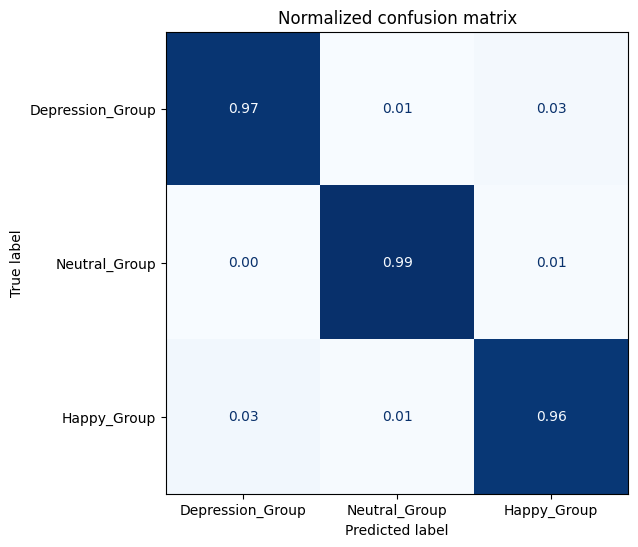

In [ ]:

#### Modeling step 12. Model evaluation Confuxion matrix
labels_names_list = dataset['train'].features['label'].names

###### validation set
measure_model_performance(trainer, df_encoded["validation"], df_encoded["validation"]['label'], labels_names_list)

{'test_loss': 0.08301085233688354, 'test_accuracy': 0.9736666666666667, 'test_precision': 0.9736362188951353, 'test_recall': 0.9736666666666667, 'test_f1': 0.9736442672121398, 'test_runtime': 10.7701, 'test_samples_per_second': 278.549, 'test_steps_per_second': 4.364}


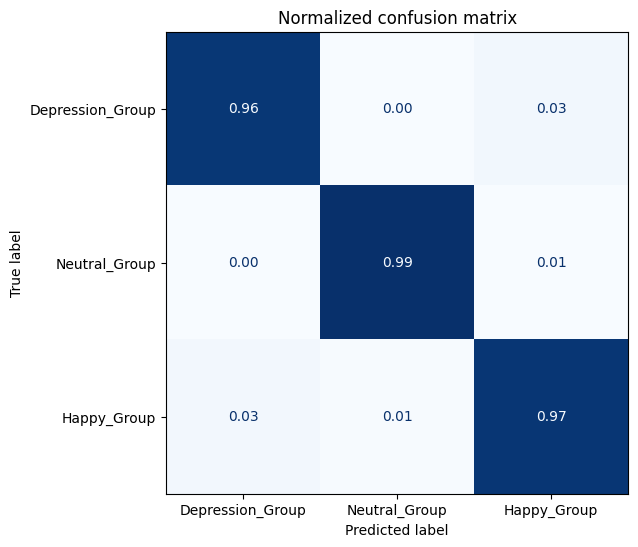

In [ ]:
###### test set
measure_model_performance(trainer, df_encoded["test"], df_encoded["test"]['label'], labels_names_list)

In [ ]:
###### Error Analysis on Test Set
model = trainer.model
df_test = analyze_error_test_set(df_encoded_src=df_encoded)
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
2065,I WENT TO THE MALL TODAY! On a Saturday aftern...,Depression_Group,Neutral_Group,6.139709
2061,For anyone dealing with Mental Health Problems...,Neutral_Group,Depression_Group,5.911517
3733,I'm finally setting up a therapy appointment I...,Neutral_Group,Depression_Group,5.851785
2752,lots of changes ahead hey guys. i’ve been feel...,Neutral_Group,Depression_Group,5.851193
1117,I took the bike to school. I've been paying 50...,Depression_Group,Neutral_Group,5.797451
1760,I'm planning to call the National Suicide Hotl...,Neutral_Group,Depression_Group,5.746561
2537,"Reddit, could you help any of these \npeople? ...",Depression_Group,Happy_Group,5.575103
3601,F/28/Depression/Anxiety/PTSD Hello everyone. I...,Neutral_Group,Depression_Group,5.524334
3620,"In your darkest hour, hope is something that y...",Neutral_Group,Depression_Group,5.447063
3147,Colonizing the Galaxy I guess this is a bit of...,Neutral_Group,Happy_Group,5.306942


In [ ]:
###### Loss Case inspection

In [ ]:
df_test.sort_values("loss", ascending=False).iloc[0]['text']

'I WENT TO THE MALL TODAY! On a Saturday afternoon of all times, wow. Never thought I would but my sister needed help buying groceries and just said yes without thinking. I exhausted but glad I went.'

In [ ]:
df_test.sort_values("loss", ascending=False).iloc[0][['label','predicted_label']]

label              Depression_Group
predicted_label       Neutral_Group
Name: 2065, dtype: object

In [ ]:
df_test.sort_values("loss", ascending=False).iloc[1]['text']

"For anyone dealing with Mental Health Problems I tried to post this elsewhere but got banned several times, yet people are making posts about being suicidal and no form of response to that. I hope this subreddit will reach at least a few people.\n\nI planned on taking my own life at the age of 32. I had it all mapped out and knew the location where I wanted to go through with it. Do I have your attention now? Please give this a chance and read it till the end.\n\nI am writing this because, in scrolling through Reddit recently, I am seeing a real uptick in people being depressed, suicidal, and worse. So I wanted to write this to tell you how I overcame and that YOU ARE NOT ALONE.\n\nWhen I was 25 years old, I was severely depressed. If anyone on the outside saw me, they would have no idea that I struggled with a never-ending sadness that seemed to get worse as I grew older. Finally, I started to wonder if life was even worth living. I mean, if this sadness is what I have to look forwar

In [ ]:
df_test.sort_values("loss", ascending=False).iloc[1][['label','predicted_label']]

label                 Neutral_Group
predicted_label    Depression_Group
Name: 2061, dtype: object

In [ ]:
#### Modeling step 13. Model save step
trainer.save_model("distil_bert_fine_tuned_emotions")

In [ ]:
###### Use saved model and load pipeline functionality
classifier = pipeline("text-classification", model="distil_bert_fine_tuned_emotions")

###### evaluation performance by unit test
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)
print(preds)

[[{'label': 'LABEL_0', 'score': 0.003520155558362603}, {'label': 'LABEL_1', 'score': 0.0014828195562586188}, {'label': 'LABEL_2', 'score': 0.9949970245361328}]]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


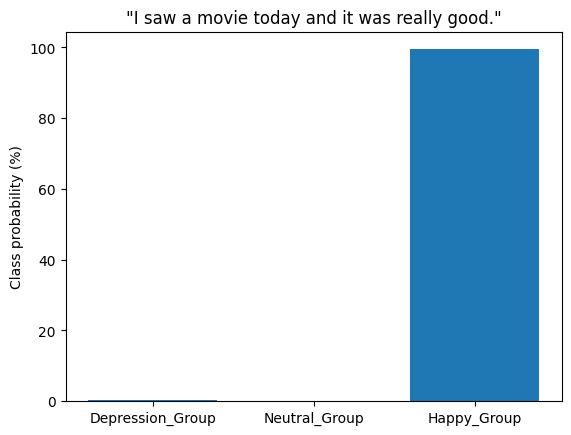

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Model performance evaluation demo

In [ ]:
#### depression class

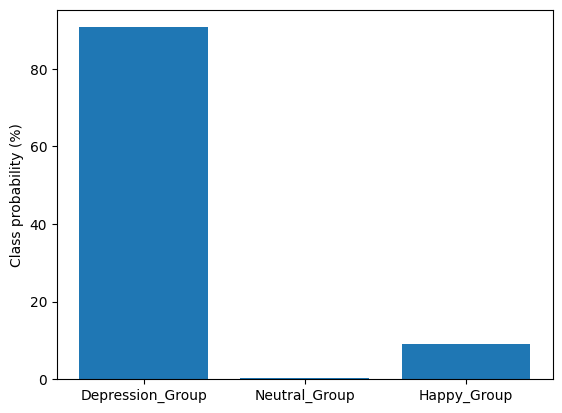

During school days, there are moments when I feel a sense of happiness, perhaps when I receive praise from a teacher or when I achieve a personal goal. However, underlying that happiness, there's often a deeper feeling of despair, like when I struggle to keep up with my classmates or when I feel isolated in a crowd. Even though there are moments of joy, the weight of hopelessness seems to overshadow them, leaving me feeling more alone than ever.


In [ ]:
custom_tweet = \
 "During school days, there are moments when I feel a sense of happiness, perhaps when I receive praise from a teacher or when I achieve a personal goal. \
However, underlying that happiness, there's often a deeper feeling of despair, like when I struggle to keep up with my classmates or when I feel isolated in a crowd. \
Even though there are moments of joy, the weight of hopelessness seems to overshadow them, leaving me feeling more alone than ever."



preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)

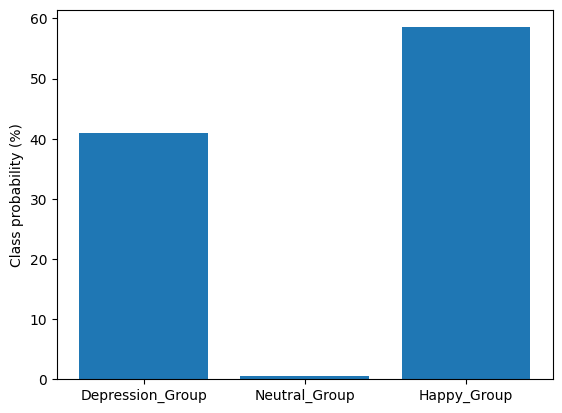

At work, there are instances when I experience moments of contentment, such as when I finish a project ahead of schedule or receive positive feedback from a colleague.Yet, despite these brief moments of happiness, there's a persistent sense of emptiness that lingers, stemming from feelings of insecurity or dissatisfaction with my career. Despite my efforts to focus on the positives, the feeling of despair remains, making it difficult to fully enjoy the successes I achieve.


In [ ]:
custom_tweet = \
"At work, there are instances when I experience moments of contentment, such as when I finish a project ahead of schedule or receive positive feedback from a colleague.\
Yet, despite these brief moments of happiness, there's a persistent sense of emptiness that lingers, stemming from feelings of insecurity or dissatisfaction with my career. \
Despite my efforts to focus on the positives, the feeling of despair remains, making it difficult to fully enjoy the successes I achieve."


preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)

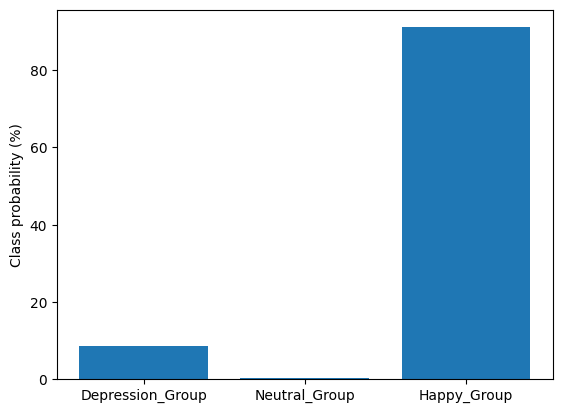

Within my family, there are times when I share moments of laughter and love with my loved ones, cherishing the bonds we share.However, amidst these moments of happiness, there's an underlying feeling of sorrow that I can't seem to shake off, stemming from unresolved conflicts or distant relationships. Despite the warmth of family connections, the weight of melancholy prevails, casting a shadow over our interactions and leaving me yearning for deeper connection and understanding.


In [ ]:
custom_tweet = \
"Within my family, there are times when I share moments of laughter and love with my loved ones, cherishing the bonds we share.\
However, amidst these moments of happiness, there's an underlying feeling of sorrow that I can't seem to shake off, stemming from unresolved conflicts or distant relationships. \
Despite the warmth of family connections, the weight of melancholy prevails, casting a shadow over our interactions and leaving me yearning for deeper connection and understanding."


preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)

In [ ]:
### happy class

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


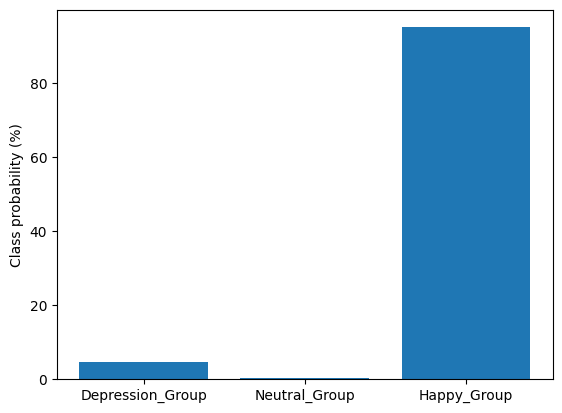

,0,1,2
label,LABEL_0,LABEL_1,LABEL_2
score,0.047308,0.002027,0.950665


In [ ]:

custom_tweet = \
"During school days, there are moments when I feel down, maybe because of a bad grade or a disagreement with a friend. \
But amidst those gloomy times, there are also moments of happiness, like when I solve a problem I've been struggling with\
or when I share a laugh with my classmates. Even though the sad moments weigh on me, the happiness I feel is a bit stronger.\
It's like finding a small flower blooming in the midst of a barren field, a tiny glimmer of light in the darkness. \
Despite the challenges, those moments of joy keep me going, reminding me that there's always something to smile about,\
even in the toughest of times."

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
preds_df.transpose()

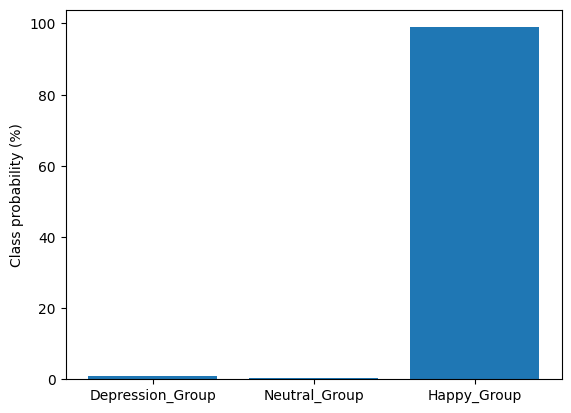

During family gatherings, there are occasions when tensions run high, perhaps due to disagreements or unresolved conflicts. But amid the occasional conflicts, there are also moments of happiness, like when we share stories and laughter around the dinner table or reminisce about fond memories. Even though arguments may arise, the warmth of family bonds prevails. It's like finding harmony in the midst of discord, a glimmer of love amidst the strife. Despite the occasional disagreements, those moments of connection keep us united, reminding us of the strength of family ties.


In [ ]:

custom_tweet = \
 "During family gatherings, there are occasions when tensions run high, perhaps due to disagreements or unresolved conflicts. \
But amid the occasional conflicts, there are also moments of happiness, like when we share stories and laughter around the dinner table or reminisce about fond memories. \
Even though arguments may arise, the warmth of family bonds prevails. It's like finding harmony in the midst of discord, a glimmer of love amidst the strife. \
Despite the occasional disagreements, those moments of connection keep us united, reminding us of the strength of family ties."



preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)



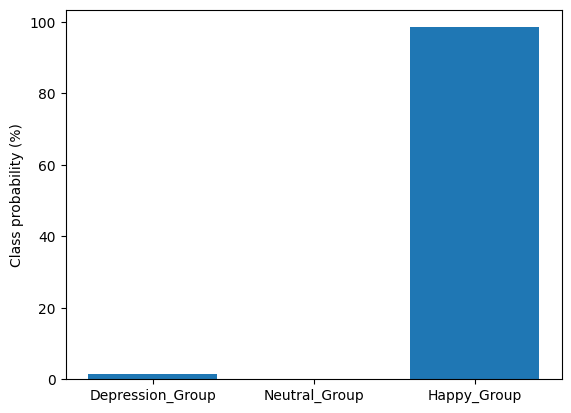

At work, there are days when I feel overwhelmed, especially when deadlines are looming or when I face criticism from my boss. But in the midst of those stressful times, there are also moments of happiness, like when I successfully complete a project or receive recognition for my hard work. Even though the pressure gets to me, the joy of accomplishment outweighs the stress. It's like finding a silver lining in a stormy sky, a brief moment of relief amidst the chaos. Despite the challenges, those small victories keep me motivated, reminding me that perseverance pays off.


In [ ]:
custom_tweet = \
"At work, there are days when I feel overwhelmed, especially when deadlines are looming or when I face criticism from my boss. \
But in the midst of those stressful times, there are also moments of happiness, like when I successfully complete a project or receive recognition for my hard work. \
Even though the pressure gets to me, the joy of accomplishment outweighs the stress. It's like finding a silver lining in a stormy sky, a brief moment of relief amidst the chaos. \
Despite the challenges, those small victories keep me motivated, reminding me that perseverance pays off."


preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)




In [ ]:
#### neutral class

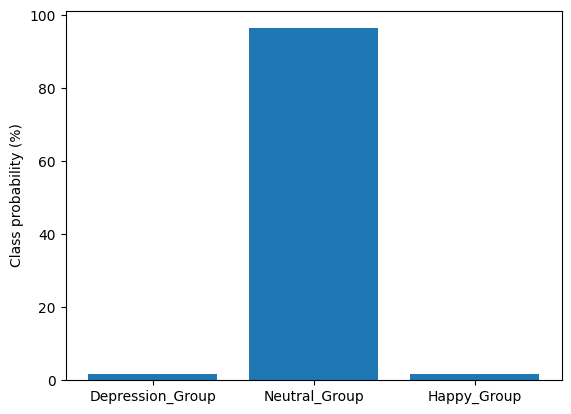

Recent studies suggest that the new policy implemented by the government has elicited a mixed response from experts in the field. While some argue for its potential benefits in addressing socioeconomic disparities, others remain skeptical, citing potential unintended consequences. Despite the divergent opinions, further research is needed to assess the long-term implications of this policy shift..


In [ ]:

custom_tweet = \
"Recent studies suggest that the new policy implemented by the government has elicited a mixed response from experts in the field.\
 While some argue for its potential benefits in addressing socioeconomic disparities, others remain skeptical, citing potential unintended consequences.\
 Despite the divergent opinions, further research is needed to assess the long-term implications of this policy shift.."

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)



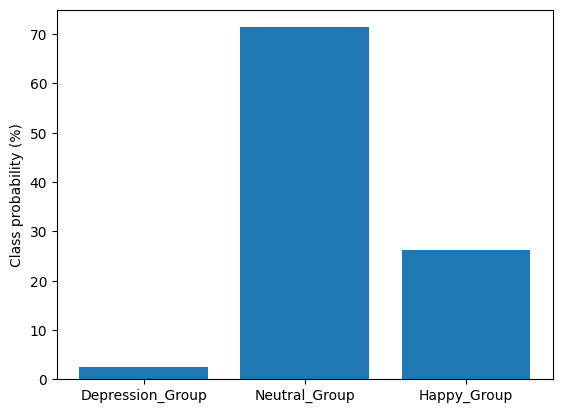

,0,1,2
label,LABEL_0,LABEL_1,LABEL_2
score,0.024664,0.714255,0.261081


In [ ]:

custom_tweet = \
"In the latest quarterly report, the company announced steady growth in revenue and market share,\
signaling stability in the face of economic uncertainty.However, analysts caution against complacency,\
highlighting potential challenges in the competitive landscape and evolving consumer preferences. \
Despite the cautious outlook, the company remains optimistic about its prospects for future growth."

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
preds_df.transpose()

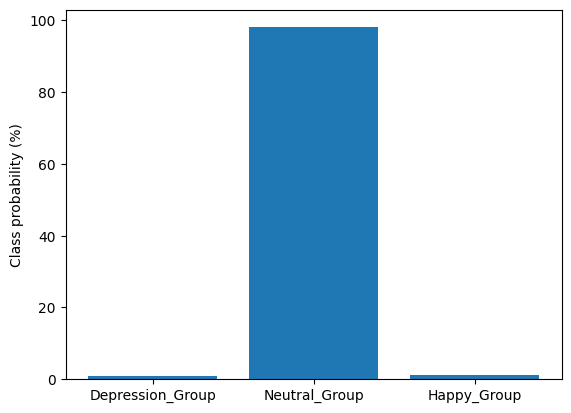

The findings from the survey reveal a nuanced perspective on the issue, with respondents expressing a range of viewpoints. While some respondents voiced support for the proposed initiative, others expressed reservations, citing concerns about feasibility and implementation challenges.  Despite the differing opinions, there is consensus on the need for further dialogue and collaboration to address the complex issues at hand.


In [ ]:

custom_tweet = \
"The findings from the survey reveal a nuanced perspective on the issue, with respondents expressing a range of viewpoints.\
 While some respondents voiced support for the proposed initiative, others expressed reservations, citing concerns about feasibility and implementation challenges.\
  Despite the differing opinions, there is consensus on the need for further dialogue and collaboration to address the complex issues at hand."


preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)



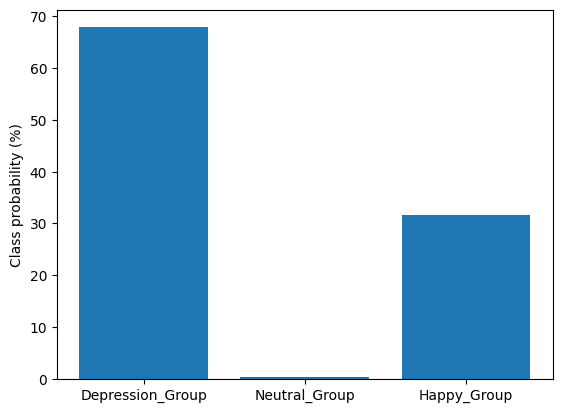

Even on a lively school day, amidst the laughter and chatter of friends, there's a quiet ache in my heart.It's like being part of the joy while  carrying a hidden weight,a faint feeling of emptiness that mutes the excitement, reminding me that even in the midst of happiness, there's a subtle shadow.


In [ ]:

custom_tweet = \
"Even on a lively school day, amidst the laughter and chatter of friends,\
 there's a quiet ache in my heart.It's like being part of the joy while \
 carrying a hidden weight,a faint feeling of emptiness that mutes the excitement,\
 reminding me that even in the midst of happiness, there's a subtle shadow."

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)

Even though the halls are filled with laughter and chatter, there's this feeling weighing on me.It's like riding the wave of excitement while also carrying a bit of sadness, a reminder that life isn't always sunshine and rainbows.Despite the energy around me, there's a cloud in my mind, making everything seem a bit less bright.It's a mix of happy and sad, like a seesaw where neither side is quite up or down. But I still hold onto hope, believing things will get better, even if they're a bit uncertain right now.


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


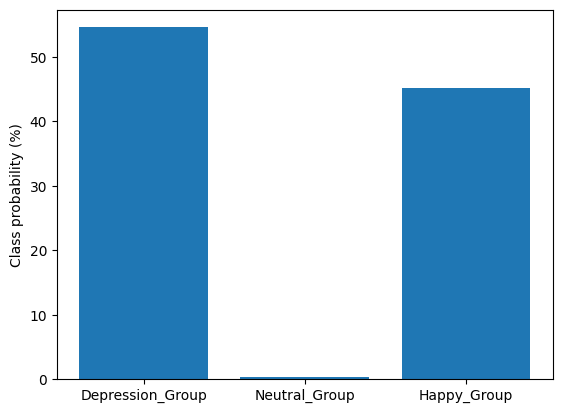

,0,1,2
label,LABEL_0,LABEL_1,LABEL_2
score,0.545592,0.003655,0.450753


In [ ]:
custom_tweet = \
"Even though the halls are filled with laughter and chatter, there's this feeling weighing on me.\
It's like riding the wave of excitement while also carrying a bit of sadness, a reminder that life isn't always sunshine and rainbows.\
Despite the energy around me, there's a cloud in my mind, making everything seem a bit less bright.\
It's a mix of happy and sad, like a seesaw where neither side is quite up or down. \
But I still hold onto hope, believing things will get better, even if they're a bit uncertain right now."

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
preds_df.transpose()
